# [ASI] Assessed exercice - Chloé Brochet Lostie de Kerhor

In [1]:
from keras.datasets import mnist, cifar10
import numpy as np
from time import time
from sklearn.metrics import confusion_matrix, log_loss, mean_squared_error
import math
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

Using TensorFlow backend.


<div class="alert alert-block alert-info"><b>1. Download the Fashion MNIST and CIFAR10 datasets and import them.</b>
</div>
## I) Download the data

In [2]:
(x_train_mnist, y_train_mnist,), (x_test_mnist, y_test_mnist) = mnist.load_data()
(x_train_cifar, y_train_cifar),(x_test_cifar, y_test_cifar) = cifar10.load_data()

In [3]:
def get_good_format(y_train_cifar): #remove the []
    y=[]
    for i in range (len(y_train_cifar)):
        y.append(y_train_cifar[i][0])
    return (y)

y_train_cifar = get_good_format(y_train_cifar)
y_test_cifar = get_good_format(y_test_cifar)

<B>MNIST database </B> : 
* the x (images) are unint8 array of grayscale image data with shape (num_samples, 28, 28)
* The y (labels) are unint8 array of digit labels (from 0 to 9) with shape num_samples.

<B>CIFAR10 small image classification</B> : 
* the x (images) are unint8 array of RGB image data with shape (num_samples, 3, 32, 32)
* The y (labels) are unint8 array of category labels (from 0 to 9) with shape num_samples.<br />
<br />


## II) Prior distribution of the labels and dimensions of the inputs

<div class="alert alert-block alert-info"><b> 2. (text) Comment on the distribution of class labels and the dimensionality of the input and how these may affect the analysis.[7] </b> </div>

### Some figures

In [4]:
number_label_MNIST = len(np.unique(y_train_mnist, return_counts=True)[0])
number_label_CIFAR = len(np.unique(y_train_cifar, return_counts=True)[0])

num_samples_MNIST = len(x_train_mnist)
num_samples_CIFAR = len(x_train_cifar)
num_samples_test_MNIST = len(x_test_mnist)
num_samples_test_CIFAR = len(x_test_cifar)

print("For MNIST dataset:")
print("Number of labels: ", number_label_MNIST)
print("Length of training set: ",num_samples_MNIST)
print("Length of test set: ",num_samples_test_MNIST,'\n ')
print("For CIFAR10 dataset:")
print("Number of labels: ",number_label_CIFAR)
print("Length of training set: ",num_samples_CIFAR)
print("Length of test set: ",num_samples_test_CIFAR)

For MNIST dataset:
Number of labels:  10
Length of training set:  60000
Length of test set:  10000 
 
For CIFAR10 dataset:
Number of labels:  10
Length of training set:  50000
Length of test set:  10000


### Computation of the labels distribution

For the MNIST, the prior is:

In [5]:
distribution_MNIST = {}
labels_mnist, c = np.unique(y_train_mnist, return_counts=True)
for i in range (10) :
    distribution_MNIST[labels_mnist[i]]=c[i]/num_samples_MNIST
    
prior_MNIST_list = []
for valeur in distribution_MNIST.values() :
    prior_MNIST_list.append(valeur) 
prior_MNIST = np.array(prior_MNIST_list)
    
print(distribution_MNIST)

{0: 0.098716666666666661, 1: 0.11236666666666667, 2: 0.099299999999999999, 3: 0.10218333333333333, 4: 0.097366666666666671, 5: 0.09035, 6: 0.098633333333333337, 7: 0.10441666666666667, 8: 0.097516666666666668, 9: 0.099150000000000002}


For the CIFAR10, the prior is:

In [6]:
distribution_CIFAR = {}
labels_CIFAR, c = np.unique(y_train_cifar, return_counts=True)
for i in range (10) :
    distribution_CIFAR[labels_CIFAR[i]]=c[i]/num_samples_CIFAR
    
prior_CIFAR_list = []
for valeur in distribution_CIFAR.values() :
    prior_CIFAR_list.append(valeur) 
prior_CIFAR = np.array(prior_CIFAR_list)
    
print(distribution_CIFAR)



{0: 0.10000000000000001, 1: 0.10000000000000001, 2: 0.10000000000000001, 3: 0.10000000000000001, 4: 0.10000000000000001, 5: 0.10000000000000001, 6: 0.10000000000000001, 7: 0.10000000000000001, 8: 0.10000000000000001, 9: 0.10000000000000001}


In [7]:
liste_of_labels = [x for x in range(10)]

<div class="alert alert-block alert-success">We notice that for CIFAR10, the distribution is exactly an uniform distribution : p(t = k) = 1/K, with K = 9 and k an integer between 0 and 9 <br/>
<br/>
<br/>
We notice that for MNIST, the distribution is not exactly an uniform distribution. This unbalance of the training data may lead to misclassify labels with less training samples. For example, the label 1 is more likely to be predicted and the label 5 will be less predicted.
</div>

### Dimensionality of the inputs

In [8]:
x_train_mnist = x_train_mnist.reshape(num_samples_MNIST,784)
x_test_mnist = x_test_mnist.reshape(len(x_test_mnist), 784)

x_train_cifar = np.asarray(x_train_cifar)
x_train_cifar = x_train_cifar.reshape(num_samples_CIFAR,3072)
x_test_cifar = np.asarray(x_test_cifar)
x_test_cifar = x_test_cifar.reshape(len(x_test_cifar),3072)

print("x_train_mnist :",x_train_mnist.shape)
print("x_test_mnist :",x_test_mnist.shape)
print("x_train_cifar :",x_train_cifar.shape)
print("x_test_cifar :",x_test_cifar.shape)

x_train_mnist : (60000, 784)
x_test_mnist : (10000, 784)
x_train_cifar : (50000, 3072)
x_test_cifar : (10000, 3072)


In [10]:
num_params_MNIST = len(x_train_mnist[0])
num_params_CIFAR = len(x_train_cifar[0])

print(num_params_MNIST)
print(num_params_CIFAR)

784
3072


Normalizing the data avoids overflows and shortens execution time. <Br/>
To facilate the next calculations, we create the lists [data,labels].

In [11]:
# ----- Normalisation -----
x_train_mnist = x_train_mnist/255
x_test_mnist = x_test_mnist/255

x_train_cifar = x_train_cifar/255
x_test_cifar = x_test_cifar/255

#intermediate list to facilate the next calculations
data_label_train_MNSIT = [x_train_mnist,y_train_mnist]
data_label_test_MNSIT = [x_test_mnist,y_test_mnist]
data_label_train_CIFAR = [x_train_cifar,y_train_cifar]
data_label_test_CIFAR = [x_test_cifar,y_test_cifar]

## III) Naive Bayesian Classifier

<div class="alert alert-block alert-info"><b>3.Classification : a) (code) Implement the Naïve Bayes classifier. [10]</b></div>

This algorithm will learn the distinctive features of a dataset and will try to predict the class of a given uncategorized example.
It is a probabilistic method which is based on the Bayes’ theorem with the naive independence assumptions between the input attributes.

We define C, a class, x a sample
P(C|x) =<sup>P(C)⋅P(x|C)</sup>&frasl;<sub>P(x)</sub>

* P(C|x): the probability of class C, given the observation x, the <B> posterior probability</B>  
* P(C): probability of class C, the <B>prior</B>
* P(x|C): probability of the observation given the class C, the <B>class likelihood</B>
* P(x): probability of the observation

As already mentioned, every attribute will be treated as independent from the others.

We compute the posterior probability for each class, so that, later, we will be able to to decide which one is the most likely (which one has the higher posterior probability).

We notice that the denominator is the same for all the classes, so we can simplify the calculation by comparing only the numerator of the Bayes’ theorem.

#### First Step: 
We convert the data set into a dictionnary with labels as keys and data as values.

In [12]:
frequency_table_train_MNIST = {}
frequency_table_test_MNIST = {}

frequency_table_train_CIFAR = {}
frequency_table_test_CIFAR = {}

# --------------- Creation of the dictionnaries with labels as keys --------------- 

    # -------- MNIST --------

for k in range(number_label_MNIST):
    frequency_table_train_MNIST[k] = [] #train
    frequency_table_test_MNIST[k] = [] #test 

    
    # -------- CIFAR --------

for k in range(number_label_CIFAR):
    frequency_table_train_CIFAR[k] = [] #train
    frequency_table_test_CIFAR[k] = [] #test 
        
# --------------- We add the values (data corresponding to each label) ---------------

    # -------- MNIST --------

for i in range(num_samples_MNIST): #train
        for k in range(number_label_MNIST):
            if data_label_train_MNSIT[1][i] == k:
                frequency_table_train_MNIST[k].append(data_label_train_MNSIT[0][i])
                
for i in range(num_samples_test_MNIST): #test
        for k in range(number_label_MNIST):
            if data_label_test_MNSIT[1][i] == k:
                frequency_table_test_MNIST[k].append(data_label_test_MNSIT[0][i])
                
    # -------- CIFAR --------

for i in range(num_samples_CIFAR): #train
        for k in range(number_label_CIFAR):
             if data_label_train_CIFAR[1][i] == k:
                frequency_table_train_CIFAR[k].append(data_label_train_CIFAR[0][i])
                
for i in range(num_samples_test_CIFAR): #test
    for k in range(number_label_CIFAR):
        if data_label_test_CIFAR[1][i] == k:
                frequency_table_test_CIFAR[k].append(data_label_test_CIFAR[0][i])

        


#### Second step: Mean and Variance
We compute the mean and the variance for each attribute for every single class. 
Since we have 784 or 3072 (for MNIST or CIFAR) attributes and 10 classes in our dataset, we will end up having two dictionnaries (mean and variance) with 10 (number of labels) keys, and arrays as value. The array contains 784 (or 3072) means (or variances).

In [13]:
def get_mean_and_variance(frequency_table_train,num_params): 
    mean, variance = {}, {}
    for k in range(len(frequency_table_train)): 
        tmp = np.asarray(frequency_table_train[k])
        mean[k] = np.mean(tmp,axis=0)
        mean[k]=mean[k].reshape(num_params)
        variance[k] = np.var(tmp,axis=0) 
        variance[k] = variance[k].reshape(num_params)
    return mean, variance 

In [14]:
def convert_meanDict_mean_array(frequency_table,num_params):
    mean,variance = get_mean_and_variance(frequency_table,num_params)
    mean_list = []
    for valeur in mean.values() :
        mean_list.append(valeur) 
    variance_list = []
    for valeur in variance.values() :
        variance_list.append(valeur)

    mean_array = np.array(mean_list)
    variance_array = np.array(variance_list)
    
    return(mean_array, variance_array, mean_list,variance_list)

#### Third step:  The log of Gaussian Probability Density Function

We use the logarithm because it's a monotone fonction. It serves as a bijective transformation of the likelihood.

For the computation of the likelihood, we assume that the components are independant for a particular class and the probability follows a Gaussian distribution.

So instead of having a product, we have a sum:
P(x|C)∗P(C)]=log[P(C)]+∑log[P(xi|C)].

In [15]:
def log_gaussian(x, m, v): 
    if v < 1e-10 : # avoid the division by 0
        v = 1e-10
    return(-0.5 * np.log(2 * np.pi * v) + (-(x - m)**2 / (2 * v)))

def log_normal_distribution(x, mean, variance,num_params):
    sum = 0
    for i in range(num_params): #784 ou 3072
        if variance[i] < 1e-10 :
            variance[i] = 1e-10
        if x[i] != 0:
            sum = sum + log_gaussian(x[i], mean[i], variance[i]) 
    return (sum)

def log_likelihood(x, means, variances,num_params): #array of likelihood for each labels
    return np.array([log_normal_distribution(x, mean, var,num_params) 
                     for mean, var in zip(means, variances)])
#return an array of 10.

#### Fourth step: Compute the postrior probabilities for each label

We have already computed the prior probability of class (uniform for CIFAR10 and almost uniform for MNIST).

In [16]:
def predictions(x, prior, means, variances,num_params): #likelihood multiplied by prior
    pred = []
    for i in range (len(prior)):
        pred.append(log_likelihood(x, means, variances,num_params)[i] + np.log(prior[i]))
    return (pred)

#### Fifth Step: Prediction

In [17]:
def predict(x, prior, means, variances, liste_of_labels,num_params):
    max_posterior = predictions(x, prior, means, variances,num_params)[0]
    index_label=0
    i=-1
    for pred in predictions(x, prior, means, variances,num_params):
        i +=1
        if pred > max_posterior :
            max_posterior= pred
            index_label = i
    label_predicted = liste_of_labels[index_label]
    return(label_predicted)
#we take the label with the maximum posterior probability

<div class="alert alert-block alert-info"><b> b)</b> (text) Describe a positive and a negative feature of the  classifier for these tasks [5] </div>

#### Pros:

* It is <B>simple</B> and <B>fast</B> to implement an algorithm and to predict class of test data set. <B>Good performance in multi class prediction too</B>.
* When certain assumption of independence holds, this classifier is <B>more efficient</B> than some other models  because <B>less</B> training data is necessary. So Naïve Bayesian Classifier in an <B>optimal</B> classifier.
* This model is unsensitive to irrelevant feature so it <B>avoids overfitting</B>.
* <B>Good performance in case of categorical input variables </B> compared to numerical variable(s). For numerical variable, normal distribution is assumed.

#### Cons

* <B>Low accuracy</B>: The model assign a zero probability to categorical variables and will be unable to make a prediction. To solve this, we can use the smoothing technique.
* The Naive Bayesian Classifier may be considered as a bad estimator for datasets with high dimensions.
* The <B>assumption of independent predictors </B> deforms the relaity, especially in our case when many features are correlated. In real life, it is almost impossible that we get a set of predictors which are completely independent. It's <B>costly</B>.



<div class="alert alert-block alert-info"><b> c)</b>(text) Describe any data pre-processing that you suggest for this data and your classifier  [5]</b> </div>
<div class="alert alert-block alert-success">
We flattened the image pixels into an 1-D array, then normalized it.
</div>

<div class="alert alert-block alert-info"><b>d)</b> (code) Apply your classifier to the two given datasets. Make sure your optimization is clearly commented. Use classification accuracy and test log-likelihood as your figures of merit [15]</div>

<B> Assessment of the performance </B>
* Accuracy is the count of predictions where your predicted value equals the actual value. 
* Log Loss takes into account the uncertainty of your prediction based on how much it varies from the actual label. This gives us a more nuanced view into the performance of our model.

In [18]:
# ------ Accuracy ------
def accuracy(prediction):
    return np.sum([p[0] == p[1] for p in prediction]) / len(prediction)

# ------ Log-lihelihood ------
#We will use the defined function log_loss from sklearn.metrics

Apply the Naive Bayesian Classifier on MNIST dataset

In [57]:
mean_MNIST_array,variance_MNIST_array,mean_list,variance_list = 
    convert_meanDict_mean_array(frequency_table_test_MNIST,num_params_MNIST)
data_label_test_MNSIT[0] = data_label_test_MNSIT[0].reshape(num_samples_test_MNIST,784)

print("Predicting 10 000 images from MNIST dataset..." )
t0 = time() 

mnist_pred = []
for i in range (len(data_label_test_MNSIT[0])):
    mnist_pred.append([data_label_test_MNSIT[1][i],
                       predict(data_label_test_MNSIT[0][i], prior_MNIST, mean_MNIST_array, 
                               variance_MNIST_array,liste_of_labels,num_params_MNIST)])

t1 = time()
mnist_pred = np.array(mnist_pred)

Predicting 10 000 images from MNIST dataset...


In [58]:
probabilities_mnist = []
for i in range(len(y_test_mnist)):
        probabilities_mnist.append(predictions(x_test_mnist[i],prior_MNIST,
                                               mean_list, variance_list,num_params_MNIST))
        

In [59]:
print("Time for 10 000 samples:", t1-t0) 
print('Accuracy Naive-Bayes: %.2f%%' % (accuracy(mnist_pred) * 100)) 
print("Log loss:",log_loss(y_test_mnist,probabilities_mnist))

Time for 10 000 samples: 7.47
Accuracy Naive-Bayes: 77.30%
Log loss: 2.21197046708


Apply the Naive Bayesian Classifier on CIFAR dataset

In [60]:
mean_CIFAR_array,variance_CIFAR_array,mean_list,variance_list = convert_meanDict_mean_array(frequency_table_test_CIFAR
                                                                                           ,num_params_CIFAR)
data_label_test_CIFAR[0] = data_label_test_CIFAR[0].reshape(num_samples_test_CIFAR,3072)

print("Predicting 10 000 images from CIFAR dataset ..." ) 
t0_NBC_cifar = time() 

cifar_pred = []
for i in range (len(data_label_test_CIFAR[0])):
    cifar_pred.append([data_label_test_CIFAR[1][i],
                       predict(data_label_test_CIFAR[0][i], prior_CIFAR, mean_CIFAR_array, 
                               variance_CIFAR_array,liste_of_labels,num_params_CIFAR)])
t1_NBC_cifar = time()
cifar_pred = np.array(cifar_pred)

Predicting 10 000 images from CIFAR dataset ...


In [61]:
probabilities_cifar = []
for i in range(len(y_test_cifar)):
    probabilities_cifar.append(predictions(x_test_cifar[i],prior_CIFAR, 
                                           mean_list, variance_list,num_params_CIFAR))

In [62]:
print("Time for 10 000 samples:", t1_NBC_cifar-t0_NBC_cifar)
print('Accuracy Naive-Bayes: %.2f%%' % (accuracy(cifar_pred) * 100))
print("Log loss:",log_loss(y_test_cifar,probabilities_cifar))


Time for 10 000 samples: 25.82
Accuracy Naive-Bayes: 29.20%
Log loss: 6.38450223687


<div class="alert alert-block alert-success">
We acheived 77,3% on the MNIST set with Naive Bayes, due to the fact that the Naive assumption is, pretty obviously, not correct. Indeed, if we're looking at a black pixel, at one of the corners, the pixels around it are more likely to be black.
<br/>
The Naive Bayes Classifier isn't accurate on the CIFAR-10 dataset.
<br/>
One of the advantages of the probabilistic classifiers is that they provide probabilities. This information is particulary important where the cost of misclassification is high.
</div>

<div class="alert alert-block alert-info"><b> e) </b>(code) Display the confusion matrix on the test data [5] </div>

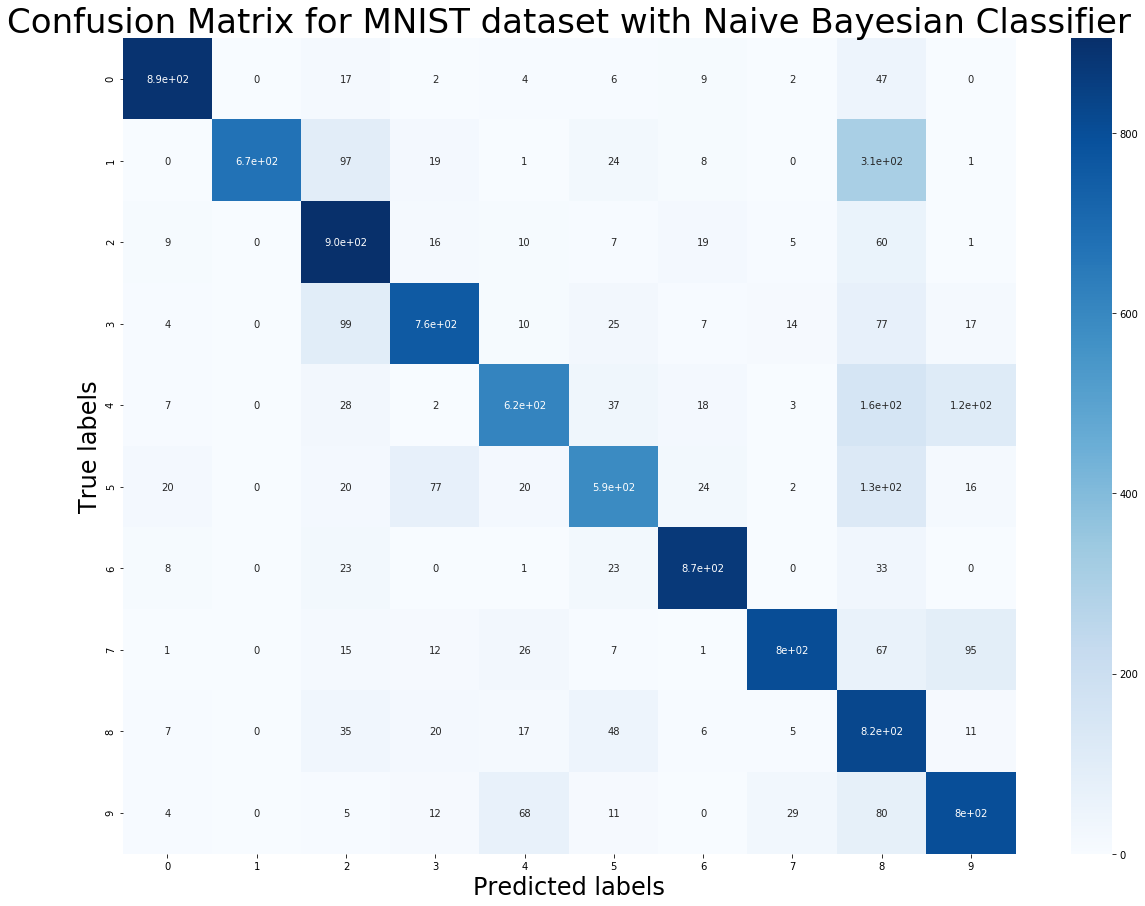

In [29]:
plt.figure(figsize = (20,15))
plt.title("Confusion Matrix for MNIST dataset with Naive Bayesian Classifier", fontsize = 34)
sns.heatmap(confusion_matrix([mnist_pred[i][0] for i in range (10000)],[mnist_pred[i][1] for i in range (10000)])
                             ,annot=True, cmap='Blues' )
plt.xlabel("Predicted labels", fontsize = 24)
plt.ylabel("True labels", fontsize = 24)
plt.show()

<div class="alert alert-block alert-success">
The diagonal relfects a high accuracy on predicting the right class.
We notice that the labels 1, 4 and 5 may be misclassified as label 9 (or 8). But globaly, the samples are well labeled.
<br/>

</div>

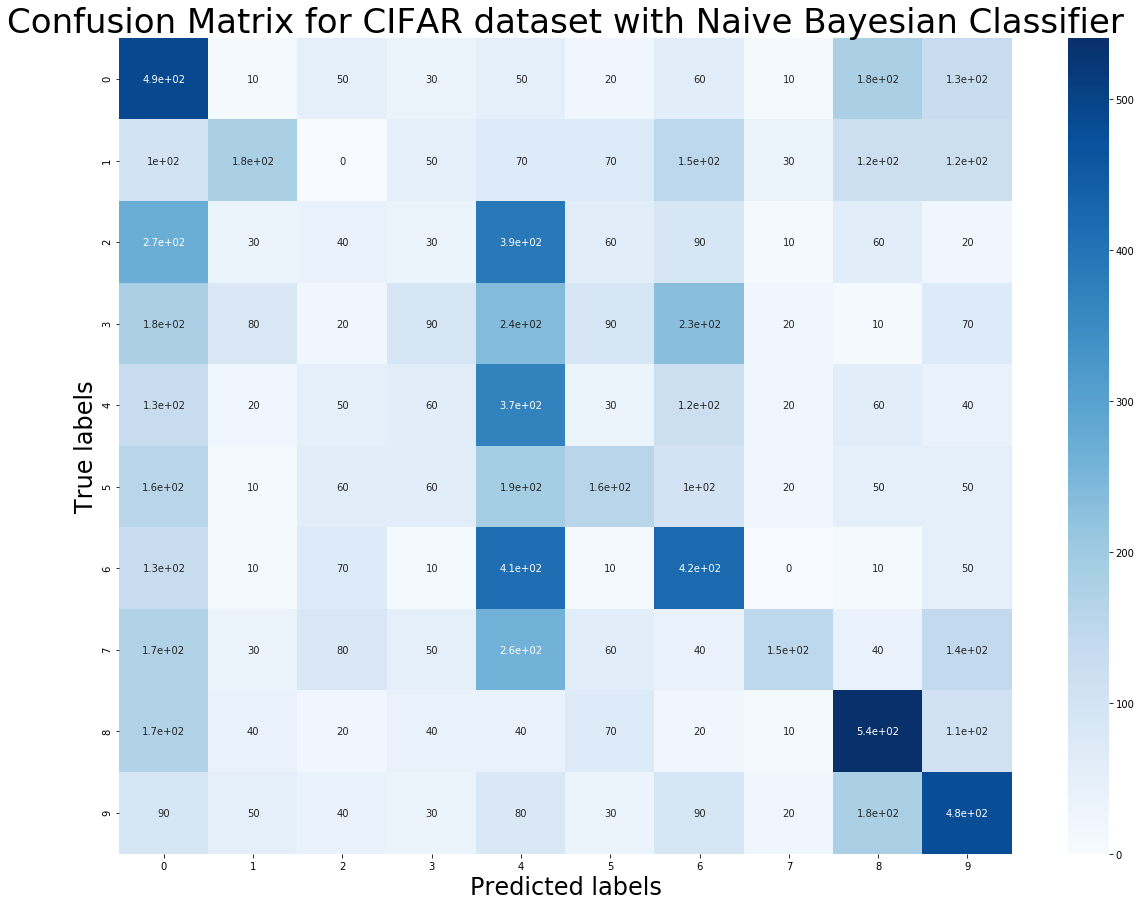

In [30]:
plt.figure(figsize = (20,15))
plt.title("Confusion Matrix for CIFAR dataset with Naive Bayesian Classifier", fontsize = 34)
sns.heatmap(confusion_matrix([cifar_pred[i][0] for i in range (10000)],[cifar_pred[i][1] for i in range (10000)])
                             ,annot=True, cmap='Blues' )
plt.xlabel("Predicted labels", fontsize = 24)
plt.ylabel("True labels", fontsize = 24)
plt.show()

<div class="alert alert-block alert-success">
This confusion matrix agrees with low accuracy, found with the algorithm.
<br/>

</div>

<div class="alert alert-block alert-info"><b> f) </b>(text) Discuss the performance, compare them against a classifier that outputs random class labels, and suggest ways in which performance could be improved [5] </div>

<B> Random Classifier </B>
The random classifier generates a random prediction for each test sample.

In [31]:
# ------ MNIST ------
t0_random = time()
mnist_random_pred = np.random.randint(0, number_label_MNIST, len(y_test_mnist))
t1_random = time()

In [32]:
# ------ CIFAR ------ 
t2_random = time()
cifar_random_pred = np.random.randint(0, number_label_CIFAR, len(y_test_cifar))
t3_random = time()

<B> Performance of the random classifier </B>

In [33]:
def get_acc(y_test_mnist,mnist_random_pred):
    c=0
    for i in range (len(y_test_mnist)):
        if y_test_mnist[i] == mnist_random_pred[i]:
            c+=1
    return(c/len(y_test_mnist))

In [34]:
# ------ MNIST ------
print("Performance of the Random Classifier for the MNIST dataset")
print("Time for 10 000 samples: %.2f" % (t1_random-t0_random))
print('Accuracy Random Classifier:', get_acc(y_test_mnist,mnist_random_pred) * 100,"%")
print("Log loss:",log_loss(y_test_mnist, [[0.1] * number_label_MNIST] * len(y_test_mnist)))

Performance of the Random Classifier for the MNIST dataset
Time for 10 000 samples: 0.01
Accuracy Random Classifier: 9.51 %
Log loss: 2.30258509299


In [35]:
# ------ CIFAR ------
print("Performance of the Random Classifier for the CIFAR dataset")
print("Time for 10 000 samples: %.2f" % (t3_random-t2_random))
print('Accuracy Random Classifier:', get_acc(y_test_cifar,cifar_random_pred) * 100,"%")
print("Log loss:",log_loss(y_test_cifar, [[0.1] * number_label_CIFAR] * len(y_test_cifar)))

Performance of the Random Classifier for the CIFAR dataset
Time for 10 000 samples: 0.00
Accuracy Random Classifier: 10.23 %
Log loss: 2.30258509299


<div class="alert alert-block alert-success">
The performance of the NBC for the MNIST dataset is better than for the CIFAR10 dataset. Even if their performances are not very high, Naive Bayesian Classifier is better than a random one. 
<br/><br/>
A way to perfom this classifier may be done by subsituting each pixels with 0 and 1 (the pixel greater than 255/2 will become 1 and the ones with a value lower than 255/2 will become 0) and normalizing after.
<br/><br/>
To improve the performance of the NBC, we should focus on the pre-processing and the fetaure selection: we should remove the correlated features. Indeed, as the highly correlated features are voted twice in the model, it can lead to false predictions.
We should take into account the spatial correlation of the pixels.

We also could have used the Principal component analysis (PCA) to convert a set of correlated parameters of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components.
</div>

## IV) Bayesian Linear Regression

<div class="alert alert-block alert-info"><b> a) </b>
(code) Implement Bayesian linear regression (you should already have an implementation from the lab sessions) [10] </div>

We assume that the prior is Gaussian. The likelihood is Gaussian too. So as the prior is conjugate to the likelihood, the posterior is Gaussian too.

The Gaussian likelihood is:
$$
p(\mathbf{t}|\mathbf{w}, \mathbf{X}, \sigma^2) = N(\mathbf{Xw}, \sigma^2\mathbf{I})
$$


The prior conjugate to the likelihood is Gaussian (S is a diagonal matrix) :

$$
p(\mathbf{w}) = N(0, S)
$$

In [36]:
def get_covariance_S(x, order=1):
    prior_cov_size = (order+1)*len(x[0])
    prior_cov = np.zeros((prior_cov_size,prior_cov_size)) + np.diag(np.random.uniform(0, 1, prior_cov_size))
    return (prior_cov)

Our goal is to estimate the posterior, which must be gaussian with unknown parameters:

$$
p(\mathbf{w}|\mathbf{X}, \mathbf{t}, \sigma^2) = N(\mathbf{\mu}, \mathbf{\Sigma})
$$

We have to find the μ and Σ.

Covariance:
$$
    \mathbf{\Sigma} = \left(\frac{1}{\sigma^2}\mathbf{X^TX} + \mathbf{S}^{-1}\right)^{-1}
$$

In [37]:
def get_covariance_sigma(X, S, variance):
    return np.linalg.inv(X.T.dot(X) / variance + np.linalg.inv(S))

Mean:
$$
    \mathbf{\mu} = \frac{1}{\sigma^2}\mathbf{\Sigma X^T t}
$$

In [38]:
def get_mean(X, t, covariance_sigma, variance):
    return covariance_sigma.dot(X.T).dot(t) / variance

We can compute expectation exactly, to give predictive density:
$$
p(t_{new}|\mathbf{X}, \mathbf{t}, \mathbf{x}_{new}, \sigma^2) = N(\mathbf{x^T}_{new}\mu, \sigma^2 + \mathbf{x^T}_{new}\mathbf{\Sigma^{-1}x}_{new})
$$

With the mean: 
$$
\mathbf{x^T}_{new}\mu
$$
and the var: 
$$
\sigma^2 + \mathbf{x^T}_{new}\mathbf{\Sigma^{-1}x}_{new}
$$

In [39]:
def bayesian_linerar_regression(x, x_test, t, variance, degree):
    S = get_covariance_S(x,degree)
    
    X = get_good_format(x, degree)
    X_test = get_good_format(x_test, degree)
    
    covariance_sigma = get_covariance_sigma(X, S, variance)
    mu = get_mean(X, t, covariance_sigma, variance)
    
    pred_mean = X_test.dot(mu)
    pred_var = (variance + X_test.dot(np.linalg.inv(covariance_sigma)).dot(X_test.T)).diagonal()
    
    mnist_pred_mean_disc = np.array([round_mean(pred) for pred in pred_mean])
    
    return (mnist_pred_mean_disc, pred_mean, pred_var)

def round_mean(value): #to avoid unexistant labels
    value = round(value)
    if value > 9: #9 is the maximum label
        value = 9
    if value < 0: #0 is the minimum label
        value = 0
    return value

In [40]:
def get_good_format(x, order):
    return np.array([np.array([x_i**n for n in range(order + 1)]).flatten() for x_i in np.array(x)])

Evaluating the posterior distribution is complex. That's why we will draw random samples from the posterior in order to approximate the posterior. The technique is one application of Monte Carlo methods.



<div class="alert alert-block alert-info"><b> b) </b>(code) Treat class labels as continuous and apply regression to the training data. [15] </div>

For the MNIST dataset:

In [46]:
t0_linear_mnist_1 = time()
mnist_pred_mean_disc_mnist, pred_mean_mnist, pred_var_mnist = bayesian_linerar_regression(x_train_mnist, x_test_mnist, y_train_mnist,
                                                                        variance = 1, degree = 1)
t1_linear_mnist_1 = time()

mnist_pred_1 = np.array([(x[0], int(pred)) for x, pred in zip(x_test_mnist, mnist_pred_mean_disc_mnist)])
label_predicted_linear_MNIST_1 = [int(mnist_pred[i][1]) for i in range (10000)]

t0_linear_mnist_2 = time()
mnist_pred_mean_disc_mnist, pred_mean_mnist, pred_var_mnist = bayesian_linerar_regression(x_train_mnist, x_test_mnist, y_train_mnist,
                                                                        variance = 1, degree = 2)
t1_linear_mnist_2 = time()

mnist_pred_2 = np.array([(x[0], int(pred)) for x, pred in zip(x_test_mnist, mnist_pred_mean_disc_mnist)])
label_predicted_linear_MNIST_2 = [int(mnist_pred[i][1]) for i in range (10000)]

In [47]:
print("Performance of the Bayesian Linear Regression for the MNIST dataset: ")
print("For the order 1:")
print("Time for 10 000 samples: %.2f" % (t1_linear_mnist_1-t0_linear_mnist_1))
print('Accuracy Bayesian Linear Regression (order %d): %.2f%%' % (1, 
                                    get_acc(y_test_mnist,label_predicted_linear_MNIST_1)*100))
print("For the order 2:")
print("Time for 10 000 samples: %.2f" % (t1_linear_mnist_2-t0_linear_mnist_2))
print('Accuracy Bayesian Linear Regression (order %d): %.2f%%' % (2, 
                                    get_acc(y_test_mnist,label_predicted_linear_MNIST_2)*100))

      

Performance of the Bayesian Linear Regression for the MNIST dataset: 
For the order 1:
Time for 10 000 samples: 22.79
Accuracy Bayesian Linear Regression (order 1): 28.29%
For the order 2:
Time for 10 000 samples: 41.87
Accuracy Bayesian Linear Regression (order 2): 28.29%


For CIFAR10 dataset:

In [49]:
t0_linear_cifar_1 = time()
pred_mean_disc_cifar, pred_mean_cifar, pred_var_cifar = bayesian_linerar_regression(x_train_cifar
                                        , x_test_cifar, y_train_cifar,variance = 1, degree = 1)
t1_linear_cifar_1 = time()

cifar_pred_1 = np.array([(x[0], int(pred)) for x, pred in zip(x_test_cifar, pred_mean_disc_cifar)])
label_predicted_linear_CIFAR_1 = [int(cifar_pred[i][1]) for i in range (10000)]

In [45]:
print("Performance of the Bayesian Linear Regression for the CIFAR10 dataset: ")
print("Time for 10 000 samples: %.2f" % (t1_linear_cifar_1-t0_linear_cifar_1))
print('Accuracy Bayesian Linear Regression (order %d): %.2f%%' % (1, 
                                    get_acc(y_test_cifar,label_predicted_linear_CIFAR_1)*100))

Performance of the Bayesian Linear Regression for the CIFAR10 dataset: 
Time for 10 000 samples: 260.79
Accuracy Bayesian Linear Regression (order 1): 11.47%


<div class="alert alert-block alert-success"> 
For the MNIST dataset, increasing the order (order 1 to order 2) doesn't increase the accuracy of the regression. The accuracy is still quite low.
<br/>
For the CIFAR10 dataset, the execution time is longer. And increasing the order takes a very long time: it is unexploitable. The accuracy is very low.
</div>

<div class="alert alert-block alert-info"><b> c) </b>(code) Produce a scatter plot showing the predictions versus the true targets for the test set and compute the  mean squared error on the test set [5] </div>

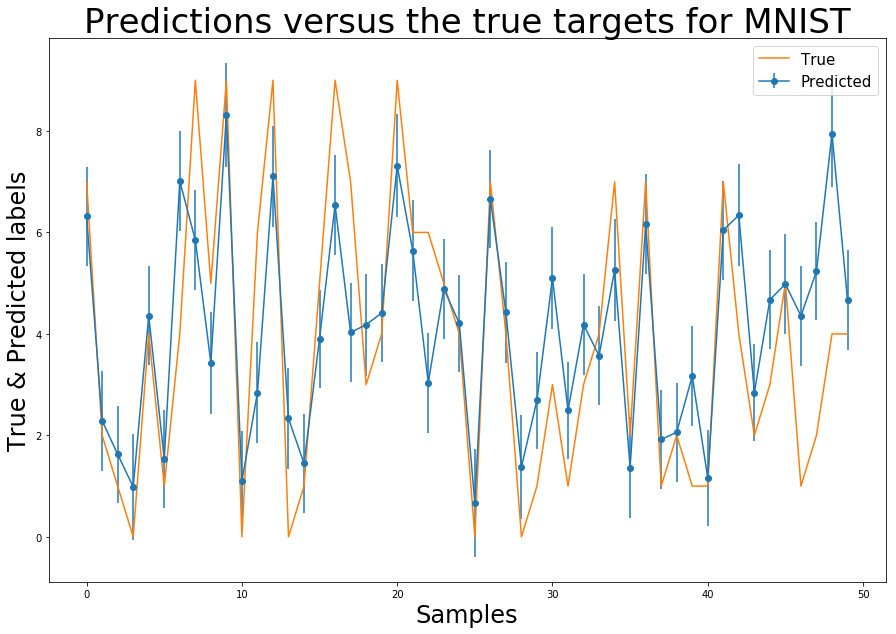

In [142]:
# ---------- MNIST ----------

limit = 50
plt.figure(figsize=(15,10))
plt.title('Predictions versus the true targets for MNIST', fontsize = 34)
plt.errorbar(range(limit), pred_mean_mnist[:limit], \
             yerr=pred_var_mnist[:limit]/np.mean(pred_var_mnist), fmt='o-', label="Predicted")
plt.plot(range(limit), y_test_mnist[:limit], label="True")
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, prop={'size':15})
plt.xlabel("Samples", fontsize = 24)
plt.ylabel("True & Predicted labels", fontsize = 24)

plt.show()


<div class="alert alert-block alert-success"> 
This model is quite accurate.
</div>


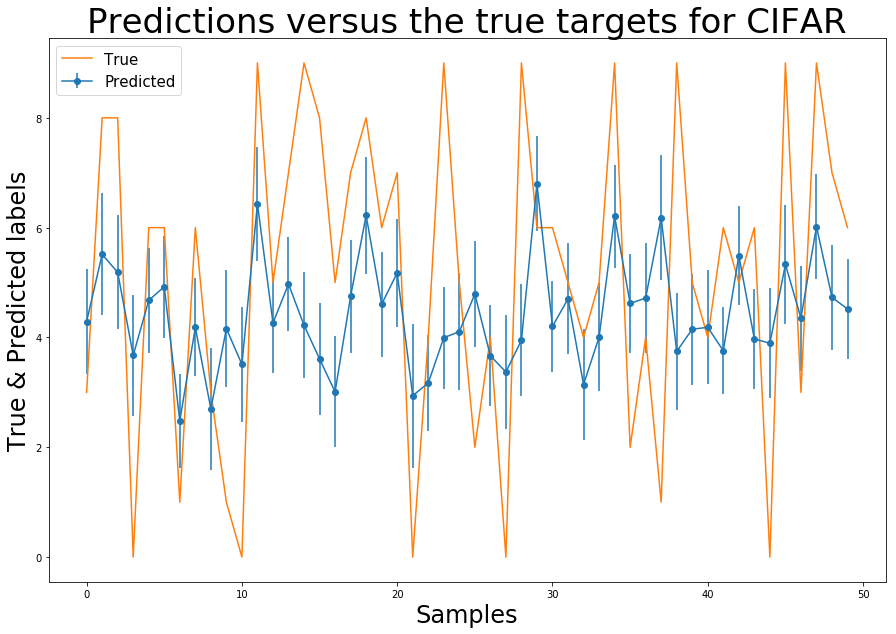

In [141]:
# ---------- CIFAR ----------

limit = 50
plt.figure(figsize=(15,10))
plt.title('Predictions versus the true targets for CIFAR', fontsize = 34)
plt.errorbar(range(limit), pred_mean_cifar[:limit], \
             yerr=pred_var_cifar[:limit]/np.mean(pred_var_cifar), fmt='o-', label="Predicted")
plt.plot(range(limit), y_test_cifar[:limit], label="True")
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, prop={'size':15})
plt.xlabel("Samples", fontsize = 24)
plt.ylabel("True & Predicted labels", fontsize = 24)

plt.show()

<div class="alert alert-block alert-success"> 
This model is not very accurate. Indeed the difference between the predicted label and the true ones is quite high.
</div>

In [50]:
# -------- MNIST --------

mnist_mse = mean_squared_error(y_test_mnist, pred_mean_mnist)

print("MSE for MNIST:", mnist_mse)

MSE for MNIST: 2.4658453411


In [51]:
# -------- CIFAR --------
cifar_mse = mean_squared_error(y_test_cifar, pred_mean_cifar)

print("MSE for CIFAR:", cifar_mse)


MSE for CIFAR: 7.80096718909


<div class="alert alert-block alert-info"><b> d) </b>(text) Suggest a way to discretize predictions and display the confusion matrix on the test data and report accuracy  [5]   </div>

<div class="alert alert-block alert-success"> 
Ror the discretization, we take the argmax of our predictions to obtain a discrete predicted label. For all the predicted labels between 0 and 9, we rounded the labels. To avoid negative predictions or predictions higher than 9, we substituted each negative value for 0 and each value higher than 9 for 9.
</div>

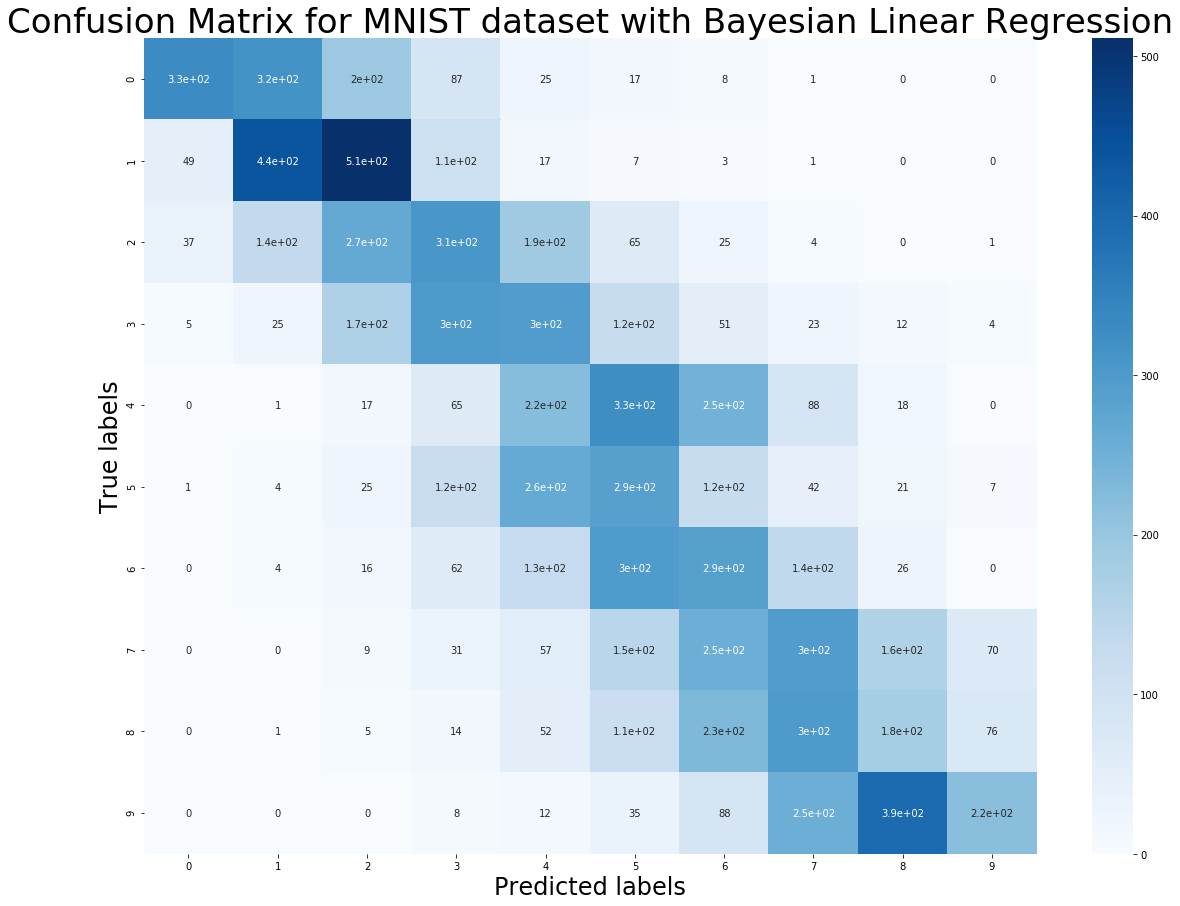

In [52]:
plt.figure(figsize = (20,15))
plt.title("Confusion Matrix for MNIST dataset with Bayesian Linear Regression", fontsize = 34)
sns.heatmap(confusion_matrix(y_test_mnist,label_predicted_linear_MNIST)
                             ,annot=True, cmap='Blues' )
plt.xlabel("Predicted labels", fontsize = 24)
plt.ylabel("True labels", fontsize = 24)
plt.show()

<div class="alert alert-block alert-success"> 
The visible diagonal is larger than the one obtained with Naive Bayesian Classifier. It agrees with the previous results, since the accuracy is lower than before.
</div>

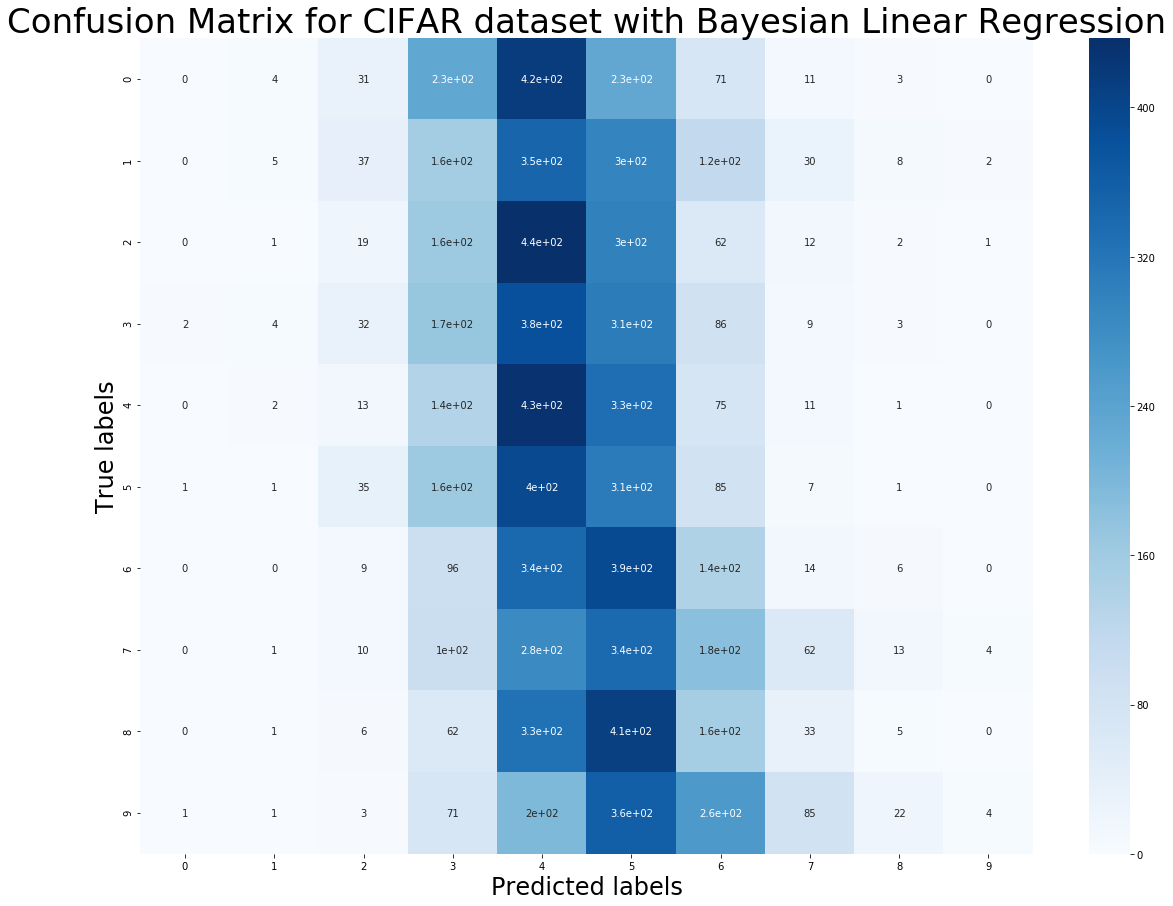

In [54]:
plt.figure(figsize = (20,15))
plt.title("Confusion Matrix for CIFAR dataset with Bayesian Linear Regression", fontsize = 34)
sns.heatmap(confusion_matrix(y_test_cifar,label_predicted_linear_CIFAR)
                             ,annot=True, cmap='Blues' )
plt.xlabel("Predicted labels", fontsize = 24)
plt.ylabel("True labels", fontsize = 24)
plt.show()

<div class="alert alert-block alert-success"> 
This vertical colomn shows that the majority of the images are misclassified as label 4 and 5. A lot of images are labeled as 3 and 6 too.
</div>

<div class="alert alert-block alert-info"><b> e) </b> (text) Discuss regression performance with respect to classification performance [5]</div>

<div class="alert alert-block alert-success"> 
The Naive Bayesian Classifier works better than the Bayesian linear regression.
<br/>
In the Bayesian Linear regression, we assumed that the relationship between images and labels is linear and will continue into the future. But this assumption is wrong, it is clearly not perfectly linear.
<br/>
Finally, to reach the optimal performance, we could use both algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone. So the ensemble of the previous methods could be a solution.
<br/>
<br/>
The probabilities, given by these two methods, have a certain cost.
</div>

<div class="alert alert-block alert-info"><b> f) </b> (text) Describe one limitation of using regression for this particular task. [5]  </div>

<div class="alert alert-block alert-success"> 
One of the limits of this regression is the assumption: assuming a linear relationship between the inputs and the labels may lead to confusions. This models does not distinguish the important features from the whole structure.

Besides, Bayesian regression relaxes the assumption that the error must have a normal distribution (the error must still be independent across observations).
</div>